In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data_dir = "/home/angps/Documents/Thesis/Data/"
image_dir = "/home/angps/Documents/Thesis/Report/Images/"

In [22]:
df_atleast_50_cts = pd.read_csv(data_dir + 'data_>=50cts.csv').T
full_df = pd.read_csv(data_dir + 'df_>=1cts.csv').T

In [23]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [24]:
train_df = df_atleast_50_cts.iloc[0:198,]
test_df = df_atleast_50_cts.iloc[198:,]

In [25]:
train_df.shape

(198, 42)

In [38]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [str(var) + '_x' for var in variables]
    df.index = [str(var) + '_y' for var in variables]
    return df

#grangers_causation_matrix(df_atleast_50_cts, variables = df_atleast_50_cts.columns)        

In [27]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(train_df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
0      ::  5287.43   > nan       =>   False
1      ::  4776.24   > nan       =>   False
2      ::  4331.37   > nan       =>   False
3      ::  3916.3    > nan       =>   False
4      ::  3575.07   > nan       =>   False
5      ::  3250.83   > nan       =>   False
6      ::  2968.64   > nan       =>   False
7      ::  2694.85   > nan       =>   False
8      ::  2449.27   > nan       =>   False
9      ::  2208.83   > nan       =>   False
10     ::  1982.38   > nan       =>   False
11     ::  1787.38   > nan       =>   False
12     ::  1600.3    > nan       =>   False
13     ::  1423.99   > nan       =>   False
14     ::  1270.51   > nan       =>   False
15     ::  1133.53   > nan       =>   False
16     ::  1003.0    > nan       =>   False
17     ::  881.33    > nan       =>   False
18     ::  777.59    > nan       =>   False
19     ::  680.75    > nan       =>   False
20     ::  593.99    > nan     

In [28]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")
    return True if p_value <= signif else False

In [39]:
#Test stationarity of clustering group (9)
cluster = pd.read_csv(data_dir + 'cluster_df.csv')
cluster = cluster.iloc[:,1:]
cluster.head()

,cluster_1_orders,cluster_2_orders,cluster_3_orders,cluster_4_orders,cluster_5_orders,cluster_6_orders,cluster_7_orders,cluster_8_orders,cluster_9_orders
0,0,0,21,8,0,14,3,5,8
1,7,0,28,13,4,11,4,0,17
2,5,0,46,21,1,25,4,4,54
3,6,0,27,24,8,20,8,9,34
4,7,1,20,2,4,17,5,4,6


In [ ]:
res = []
for name, column in cluster.iteritems():
    res.append(adfuller_test(column, name=column.name))
    print('\n')


In [41]:
cluster_diff = cluster.diff().dropna()
cluster_diff.head()

,cluster_1_orders,cluster_2_orders,cluster_3_orders,cluster_4_orders,cluster_5_orders,cluster_6_orders,cluster_7_orders,cluster_8_orders,cluster_9_orders
1,7.0,0.0,7.0,5.0,4.0,-3.0,1.0,-5.0,9.0
2,-2.0,0.0,18.0,8.0,-3.0,14.0,0.0,4.0,37.0
3,1.0,0.0,-19.0,3.0,7.0,-5.0,4.0,5.0,-20.0
4,1.0,1.0,-7.0,-22.0,-4.0,-3.0,-3.0,-5.0,-28.0
5,-2.0,0.0,-12.0,-2.0,-1.0,-17.0,-5.0,-4.0,-5.0


In [ ]:
res = []
for name, column in cluster_diff.iteritems():
    res.append(adfuller_test(column, name=column.name))
    print('\n')


In [29]:
df_differenced = full_df.diff().dropna()
df_differenced.head()


,0,1,2,3,4,5,6,7,8,9,...,703,704,705,706,707,708,709,710,711,712
2,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# ADF Test on each column
#  for name, column in train_df.iteritems():
#     adfuller_test(column, name=column.name)
#     print('\n')
res = []
for name, column in df_differenced.iteritems():
    res.append(adfuller_test(column, name=column.name))
    print('\n')
print(res==[True for i in range(713)])

In [42]:
#model = VAR(train_df)
model = VAR(cluster)

In [43]:
result = model.fit(maxlags=12)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 18, Jan, 2020
Time:                     19:19:24
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                    41.5516
Nobs:                     192.000    HQIC:                   31.6487
Log likelihood:          -3862.08    FPE:                2.59884e+11
AIC:                      24.9078    Det(Omega_mle):     4.54352e+09
--------------------------------------------------------------------
Results for equation cluster_1_orders
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                       -2.018110         1.008243           -2.002           0.045
L1.cluster_1_orders          0.072206         0.109597            0.659           0.510
L1.cluster_2_orders  

In [ ]:
for i in [1,2]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

In [44]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,31.00,31.15,2.904e+13,31.06
1,26.64,28.16*,3.704e+11,27.26*
2,26.77,29.67,4.255e+11,27.95
3,26.97,31.24,5.239e+11,28.70
4,26.84,32.49,4.727e+11,29.13
5,26.71,33.74,4.349e+11,29.56
6,26.35,34.74,3.209e+11,29.75
7,26.12,35.89,2.791e+11,30.07
8,26.19,37.33,3.391e+11,30.70
9,26.45,38.97,5.191e+11,31.52


In [45]:
model_fitted = model.fit(2)
#model_fitted.summary()

In [46]:
def adjust(val, length= 6): 
    return str(val).ljust(length)
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(train_df.columns, out):
    print(adjust(col), ':', round(val, 2))

0      : 1.94
1      : 1.96
2      : 1.96
3      : 2.04
4      : 1.97
5      : 1.98
6      : 1.95
7      : 1.91
8      : 2.01


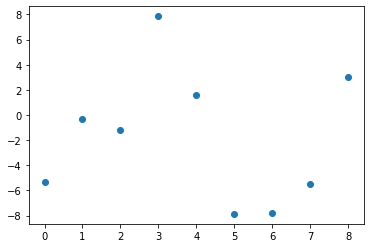

In [47]:
plt.scatter(range(len(model_fitted.resid.values[5])), model_fitted.resid.values[5])

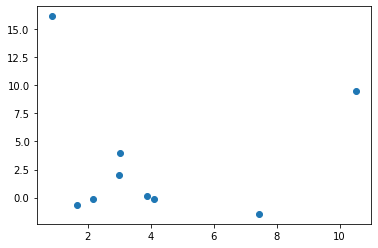

In [48]:
plt.scatter(model_fitted.fittedvalues.values[2], model_fitted.resid.values[2])

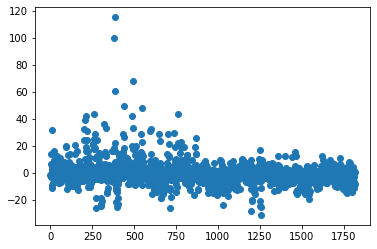

In [49]:
plt.scatter(range(len(model_fitted.resid.values.flatten())), model_fitted.resid.values.flatten())

(array([2.400e+01, 5.630e+02, 1.145e+03, 6.100e+01, 1.700e+01, 4.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([-31.20801638, -16.55800456,  -1.90799274,  12.74201908,
         27.39203089,  42.04204271,  56.69205453,  71.34206634,
         85.99207816, 100.64208998, 115.2921018 ]),
 <a list of 10 Patch objects>)

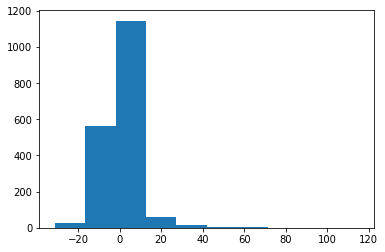

In [50]:
plt.hist(model_fitted.resid.values.flatten())

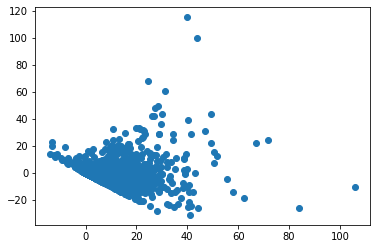

In [51]:
plt.scatter(model_fitted.fittedvalues.values.flatten(), model_fitted.resid.values.flatten())

In [52]:
forecast_input = train_df.values[-2:]
forecast_input

array([[1, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 2, 0, 1, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [53]:
df_atleast_50_cts.shape

(204, 42)

In [54]:
df_atleast_50_cts.columns = [str(i) for i in range(42)]
df_atleast_50_cts.columns 

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41'],
      dtype='object')

In [ ]:
fc = model_fitted.forecast(y=forecast_input, steps=6)
df_forecast = pd.DataFrame(fc, index=df_atleast_50_cts.index[-6:], columns=df_atleast_50_cts.columns + '_1d')
df_forecast

In [ ]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(train_df, df_forecast) 

In [ ]:
def compute_errors(pred, act):
    err = np.square(np.subtract(pred, act)).sum()
    return err

In [ ]:
act = df_atleast_50_cts.iloc[198:,:].values
act.shape

In [ ]:
pred = df_results.iloc[:,42:].values
pred.shape

In [ ]:
loss = []
fitted = []
SFE = 0
for i in range(len(act)):
    forecast = fc[i]
    actual = pred[i]
    loss.extend(forecast-actual)
    forecast_err = compute_errors(forecast, actual)
    #forecast_err = compute_errors(forecast, train)
    SFE += forecast_err
print("MSFE for VAR model on subset of dataset: " + str(round(SFE/6, 3)))

In [55]:
model_fitted.is_stable()

True

In [56]:
model_fitted.test_normality().summary()

Test statistic,Critical value,p-value,df
6126.,28.87,0.000,18


In [57]:
model_fitted.test_whiteness().summary()

Test statistic,Critical value,p-value,df
835.9,708.3,0.000,648
